# Neural Network (MLP) - Binary Classification

**Modello:** Multi-Layer Perceptron con supporto GPU (CUDA/MPS)

**Dataset:** Processed v4 hybrid (43 features, 314k samples)

**Bilanciamento:** Class weights (no SMOTE per performance)

**Architettura:**
- Input layer: 43 features
- Hidden layers: [128, 64, 32] con ReLU + Dropout
- Output layer: 1 neuron + Sigmoid
- Loss: Binary Cross-Entropy con class weights

**Hardware:** Supporto per GPU NVIDIA (CUDA), Apple Silicon (MPS) o CPU

## 1. Setup

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score
)
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('whitegrid')

# Verifica disponibilità GPU (CUDA > MPS > CPU)
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Device: {device} ({torch.cuda.get_device_name(0)})")
    print(f"CUDA version: {torch.version.cuda}")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f"Device: {device} (Metal Performance Shaders)")
else:
    device = torch.device('cpu')
    print(f"Device: {device}")

print(f"PyTorch version: {torch.__version__}")

Device: cuda (NVIDIA GeForce RTX 3060 Ti)
CUDA version: 12.1
PyTorch version: 2.5.1+cu121


## 2. Caricamento e Preprocessing

In [14]:
print("Caricamento dati...\n")

X_train = pd.read_csv('../data/processed_v4_hybrid/X_train.csv')
X_test = pd.read_csv('../data/processed_v4_hybrid/X_test.csv')
y_train = pd.read_csv('../data/processed_v4_hybrid/y_train.csv')['BinaryIncidentGrade']
y_test = pd.read_csv('../data/processed_v4_hybrid/y_test.csv')['BinaryIncidentGrade']

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"\nClass distribution: {y_train.value_counts().to_dict()}")

Caricamento dati...

X_train: (304848, 43)
X_test: (149537, 43)

Class distribution: {0: 152424, 1: 152424}


In [15]:
from sklearn.model_selection import train_test_split

print("Creazione validation set (20% del training set)...\n")

# Split training in train e validation (stratificato)
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

print(f"X_train_final: {X_train_final.shape}")
print(f"X_val:         {X_val.shape}")
print(f"X_test:        {X_test.shape}")

print(f"\nDistribuzione y_train_final:")
print(y_train_final.value_counts(normalize=True))
print(f"\nDistribuzione y_val:")
print(y_val.value_counts(normalize=True))

print("\n✅ Validation set creato. Verrà usato per monitorare il training.")

# Standardizzazione DOPO lo split (importante per NN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Dati standardizzati")
print(f"   Train: {X_train_scaled.shape}")
print(f"   Val:   {X_val_scaled.shape}")
print(f"   Test:  {X_test_scaled.shape}")

Creazione validation set (20% del training set)...

X_train_final: (243878, 43)
X_val:         (60970, 43)
X_test:        (149537, 43)

Distribuzione y_train_final:
BinaryIncidentGrade
0    0.5
1    0.5
Name: proportion, dtype: float64

Distribuzione y_val:
BinaryIncidentGrade
1    0.5
0    0.5
Name: proportion, dtype: float64

✅ Validation set creato. Verrà usato per monitorare il training.

✅ Dati standardizzati
   Train: (243878, 43)
   Val:   (60970, 43)
   Test:  (149537, 43)


## 2.1. Creazione Validation Set

## 3. Calcolo Class Weights

In [16]:
# Calcola class weights per bilanciare loss (su train_final)
class_counts = y_train_final.value_counts().sort_index()
total = len(y_train_final)

# Weight inversamente proporzionale alla frequenza
weight_class_0 = total / (2 * class_counts[0])
weight_class_1 = total / (2 * class_counts[1])

class_weights = torch.tensor([weight_class_1], dtype=torch.float32).to(device)

print(f"Class 0 weight: {weight_class_0:.4f}")
print(f"Class 1 weight: {weight_class_1:.4f} (pos_weight per BCEWithLogitsLoss)")
print(f"\nRatio: {weight_class_1/weight_class_0:.2f}x più peso alla classe minoritaria")

Class 0 weight: 1.0000
Class 1 weight: 1.0000 (pos_weight per BCEWithLogitsLoss)

Ratio: 1.00x più peso alla classe minoritaria


## 4. Preparazione DataLoaders

In [17]:
# Converti a tensori PyTorch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_final.values, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches:   {len(val_loader)}")
print(f"Test batches:  {len(test_loader)}")

Train batches: 477
Val batches:   120
Test batches:  293


## 5. Definizione Modello MLP

In [18]:
class MLP(nn.Module):
    def __init__(self, input_dim, dropout=0.3):
        super(MLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(dropout),
            
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.network(x)

# Inizializza modello
input_dim = X_train_scaled.shape[1]
model = MLP(input_dim, dropout=0.3).to(device)

# Loss con class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

MLP(
  (network): Sequential(
    (0): Linear(in_features=43, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)

Total parameters: 16,449


## 6. Training Loop

In [19]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())
    
    return np.array(all_labels).flatten(), np.array(all_preds).flatten(), np.array(all_probs).flatten()

# Training
print("Training MLP...\n")
n_epochs = 50
train_losses = []
val_aucs = []

for epoch in range(n_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    if (epoch + 1) % 5 == 0:
        # Valuta su validation set (non test!)
        y_val_true, y_val_pred, y_val_probs = evaluate(model, val_loader, device)
        val_auc = roc_auc_score(y_val_true, y_val_probs)
        val_aucs.append(val_auc)
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {train_loss:.4f} - Val AUC: {val_auc:.4f}")

print("\n✅ Training completato!")
print("⚠️ Il validation set è stato usato solo per monitorare il training.")
print("   Il test set rimane intoccato per la valutazione finale.")

Training MLP...

Epoch 5/50 - Loss: 0.4149 - Val AUC: 0.9087
Epoch 10/50 - Loss: 0.3680 - Val AUC: 0.9195
Epoch 15/50 - Loss: 0.3549 - Val AUC: 0.9246
Epoch 20/50 - Loss: 0.3476 - Val AUC: 0.9263
Epoch 25/50 - Loss: 0.3447 - Val AUC: 0.9279
Epoch 30/50 - Loss: 0.3432 - Val AUC: 0.9270
Epoch 35/50 - Loss: 0.3406 - Val AUC: 0.9266
Epoch 40/50 - Loss: 0.3384 - Val AUC: 0.9277
Epoch 45/50 - Loss: 0.3381 - Val AUC: 0.9287
Epoch 50/50 - Loss: 0.3371 - Val AUC: 0.9287

✅ Training completato!
⚠️ Il validation set è stato usato solo per monitorare il training.
   Il test set rimane intoccato per la valutazione finale.


## 7. Training Curve

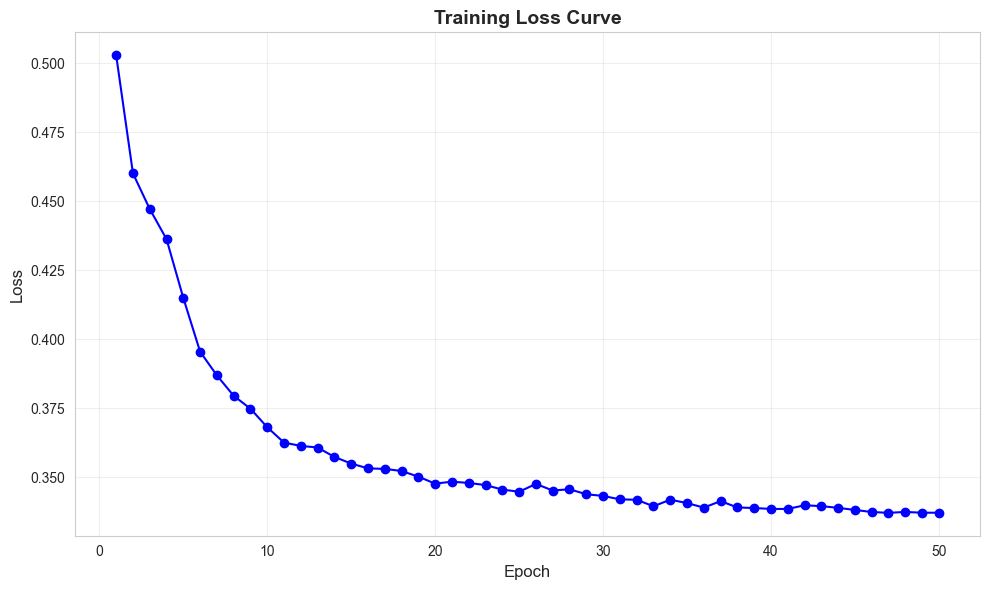

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs+1), train_losses, marker='o', color='blue')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Curve', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Evaluation

In [21]:
y_true, y_pred, y_probs = evaluate(model, test_loader, device)

print("="*70)
print("PERFORMANCE TEST SET - MLP")
print("="*70)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, 
                           target_names=['Non-TP', 'TP'], digits=4))

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_probs)

print(f"\nPRECISION: {precision:.4f}")
print(f"RECALL:    {recall:.4f}")
print(f"F1-SCORE:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f} ⭐")

PERFORMANCE TEST SET - MLP

Classification Report:
              precision    recall  f1-score   support

      Non-TP     0.8976    0.9166    0.9070    105987
          TP     0.7860    0.7456    0.7653     43550

    accuracy                         0.8668    149537
   macro avg     0.8418    0.8311    0.8361    149537
weighted avg     0.8651    0.8668    0.8657    149537


PRECISION: 0.7860
RECALL:    0.7456
F1-SCORE:  0.7653
ROC AUC:   0.9201 ⭐


## 9. Confusion Matrix

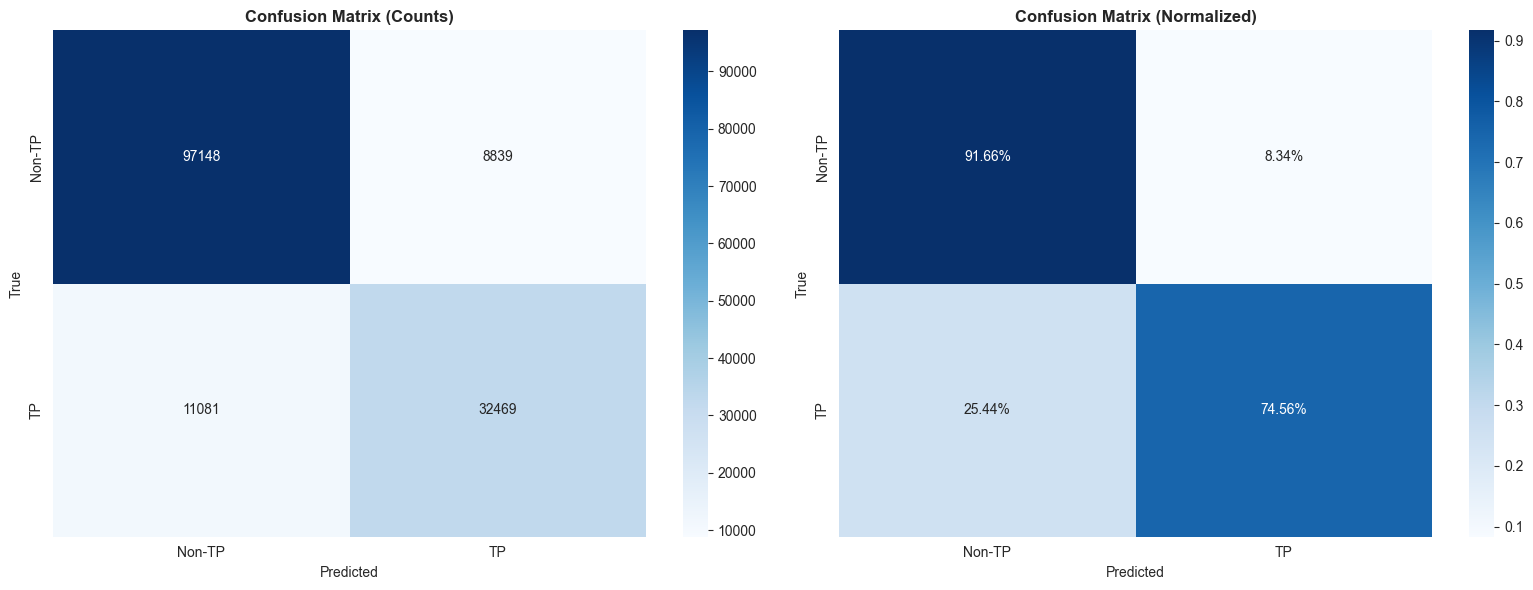

In [22]:
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-TP', 'TP'],
            yticklabels=['Non-TP', 'TP'], ax=axes[0])
axes[0].set_title('Confusion Matrix (Counts)', fontweight='bold')
axes[0].set_ylabel('True')
axes[0].set_xlabel('Predicted')

sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['Non-TP', 'TP'],
            yticklabels=['Non-TP', 'TP'], ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized)', fontweight='bold')
axes[1].set_ylabel('True')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

## 10. ROC Curve

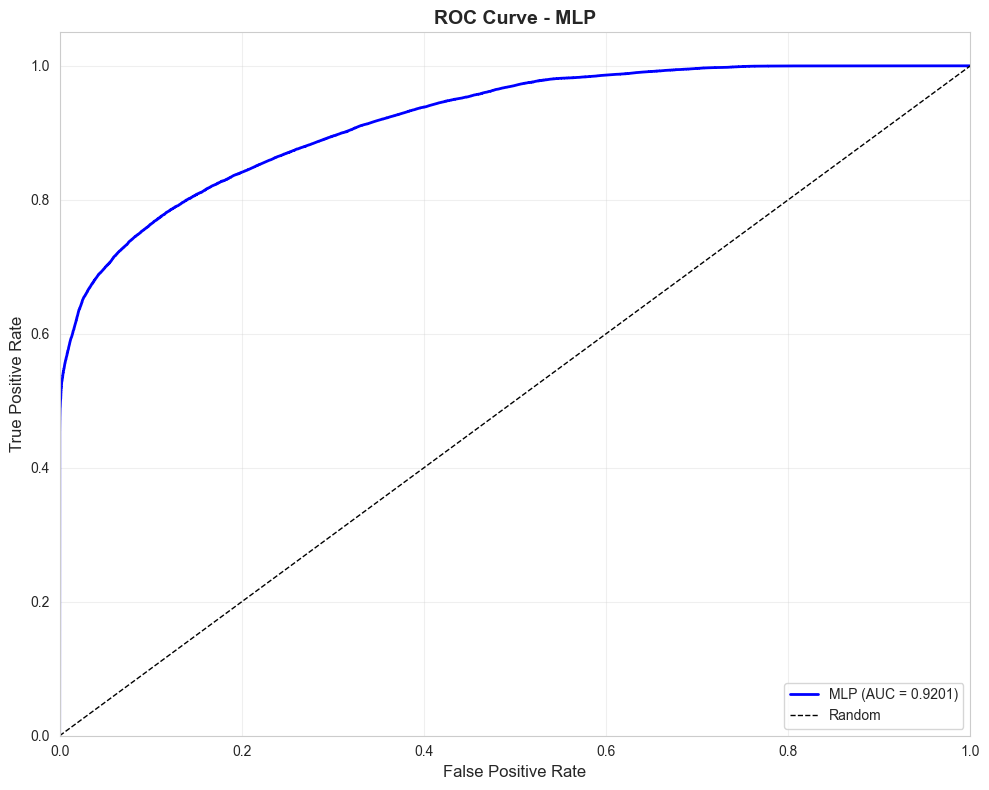

In [23]:
fpr, tpr, _ = roc_curve(y_true, y_probs)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'MLP (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - MLP', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Summary

**Architettura:** MLP [128 → 64 → 32] con Dropout e BatchNorm

**Bilanciamento:** Class weights in loss function (no SMOTE per efficienza)

**Accelerazione:** Metal Performance Shaders (MPS) su Apple Silicon

**Vantaggi NN:**
- ✅ Cattura relazioni non-lineari complesse
- ✅ Scalabile a dataset grandi
- ✅ Batch normalization stabilizza training

**Tuning possibile:**
- Aumentare epochs con early stopping
- Learning rate scheduling
- Architettura più profonda/larga

In [25]:
import os
import json
from pathlib import Path
from datetime import datetime
from sklearn.metrics import accuracy_score

# Crea directory per il modello
model_dir = Path('../models/mlp_baseline')
model_dir.mkdir(parents=True, exist_ok=True)

# Salva modello PyTorch (checkpoint completo)
model_path = model_dir / 'model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'input_dim': input_dim,
    'dropout': 0.3,
    'n_epochs': n_epochs,
    'final_loss': train_losses[-1],
    'pos_weight': float(class_weights[0].item())
}, model_path)

print(f"✅ Modello salvato: {model_path}")

# Salva solo i pesi (più leggero)
weights_path = model_dir / 'model_weights.pth'
torch.save(model.state_dict(), weights_path)
print(f"✅ Pesi salvati: {weights_path}")

✅ Modello salvato: ..\models\mlp_baseline\model.pth
✅ Pesi salvati: ..\models\mlp_baseline\model_weights.pth


In [26]:
import json
from sklearn.metrics import accuracy_score

# Calcola metriche dettagliate per ogni classe
precision_0 = precision_score(y_true, y_pred, pos_label=0)
recall_0 = recall_score(y_true, y_pred, pos_label=0)
f1_0 = f1_score(y_true, y_pred, pos_label=0)

precision_1 = precision_score(y_true, y_pred, pos_label=1)
recall_1 = recall_score(y_true, y_pred, pos_label=1)
f1_1 = f1_score(y_true, y_pred, pos_label=1)

# Salva metriche in JSON
metrics = {
    "model_name": "MLP_Baseline",
    "timestamp": datetime.now().isoformat(),
    "dataset_version": "processed_v3_balanced",
    "class_balancing": "Class weights in loss function",
    "architecture": {
        "input_dim": input_dim,
        "hidden_layers": [128, 64, 32],
        "dropout": 0.3,
        "activation": "ReLU",
        "output_activation": "Sigmoid"
    },
    "training": {
        "n_epochs": n_epochs,
        "batch_size": 512,
        "optimizer": "Adam",
        "learning_rate": 0.005,
        "loss_function": "BCEWithLogitsLoss",
        "pos_weight": float(class_weights[0].item()),
        "device": str(device)
    },
    "data": {
        "n_train_samples": len(y_train_final),
        "n_val_samples": len(y_val),
        "n_test_samples": len(y_test),
        "n_features": input_dim,
        "class_distribution_train": {
            "class_0": int((y_train_final == 0).sum()),
            "class_1": int((y_train_final == 1).sum())
        }
    },
    "test_metrics": {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "precision": float(precision),
        "recall": float(recall),
        "f1_score": float(f1),
        "roc_auc": float(roc_auc)
    },
    "per_class_metrics": {
        "class_0_non_tp": {
            "precision": float(precision_0),
            "recall": float(recall_0),
            "f1_score": float(f1_0)
        },
        "class_1_tp": {
            "precision": float(precision_1),
            "recall": float(recall_1),
            "f1_score": float(f1_1)
        }
    },
    "confusion_matrix": {
        "true_negatives": int(cm[0, 0]),
        "false_positives": int(cm[0, 1]),
        "false_negatives": int(cm[1, 0]),
        "true_positives": int(cm[1, 1])
    },
    "training_history": {
        "final_loss": float(train_losses[-1]),
        "min_loss": float(min(train_losses)),
        "loss_history": [float(loss) for loss in train_losses]
    },
    "note": "Validation set (20% of train) used for monitoring during training. Test set used only for final evaluation."
}

metrics_path = model_dir / 'metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"✅ Metriche salvate: {metrics_path}")

print(f"\n{'='*60}")
print("RIEPILOGO SALVATAGGIO")
print(f"{'='*60}")
print(f"Directory: {model_dir}")
print(f"  - model.pth (modello completo)")
print(f"  - model_weights.pth (solo pesi)")
print(f"  - metrics.json (metriche)")
print(f"{'='*60}")

✅ Metriche salvate: ..\models\mlp_baseline\metrics.json

RIEPILOGO SALVATAGGIO
Directory: ..\models\mlp_baseline
  - model.pth (modello completo)
  - model_weights.pth (solo pesi)
  - metrics.json (metriche)


## 11. Salvataggio Modello e Metriche